In [183]:
import explore
import fwd_net, spirals_fun

import torch

from matplotlib import pyplot as plt

import backpack
import copy

In [184]:
blue, red = spirals_fun.gen_spiral(1000, 1.5, .5)

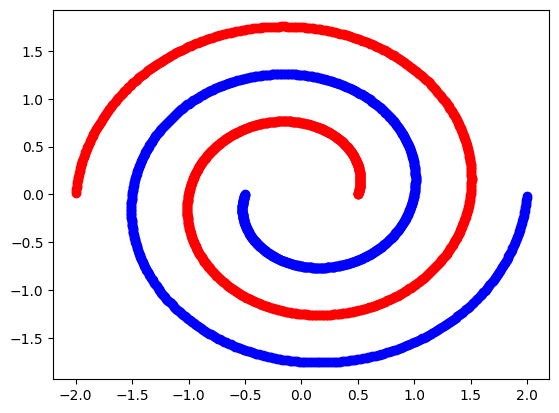

In [185]:
spirals_fun.plot_spiral(blue, red)

In [186]:
net = fwd_net.feed_forward(2, 100)

In [187]:
net(blue[0:10])

tensor([[-0.1133, -0.0712],
        [-0.1135, -0.0713],
        [-0.1136, -0.0714],
        [-0.1138, -0.0714],
        [-0.1140, -0.0715],
        [-0.1141, -0.0716],
        [-0.1143, -0.0716],
        [-0.1145, -0.0717],
        [-0.1146, -0.0718],
        [-0.1148, -0.0718]], grad_fn=<AddmmBackward0>)

In [188]:
data_x = torch.cat((blue, red), 0)

In [189]:
data_y = torch.cat((torch.zeros(blue.size(0), dtype=torch.float32), torch.ones(red.size(0),dtype=torch.float32)), 0)

In [190]:
loss_func = torch.nn.CrossEntropyLoss()

backpack.extend(net)
backpack.extend(loss_func)

CrossEntropyLoss()

In [191]:
loss = loss_func(net(data_x), data_y.long())

with backpack.backpack(backpack.extensions.KFAC()):
    loss.backward()

In [192]:
for p in net.parameters():
    if len (p.kfac) == 1:
        p.precond = torch.linalg.inv(p.kfac[0] + 1e-3 * torch.eye(p.kfac[0].size(0)))
    if len (p.kfac) == 2:
        p.precond = torch.kron(torch.linalg.inv(p.kfac[0] + 1e-3 * torch.eye(p.kfac[0].size(0))), torch.linalg.inv(p.kfac[1] + 1e-3 * torch.eye(p.kfac[1].size(0))))

In [193]:
for p in net.parameters():
    print(p.precond.shape)

torch.Size([200, 200])
torch.Size([100, 100])
torch.Size([10000, 10000])
torch.Size([100, 100])
torch.Size([200, 200])
torch.Size([2, 2])


In [194]:
torch.manual_seed(0)
base_net = fwd_net.feed_forward(2, 100)
backpack.extend(base_net)
alpha = 1e-2

losses = []

for k in range(500):
    loss = loss_func(base_net(data_x), data_y.long())
    base_net.zero_grad()
    loss.backward()
    with torch.no_grad():
        for p in base_net.parameters():
            p.data -= alpha * p.grad
            p.grad.zero_()
    
    losses.append(float(loss))
    

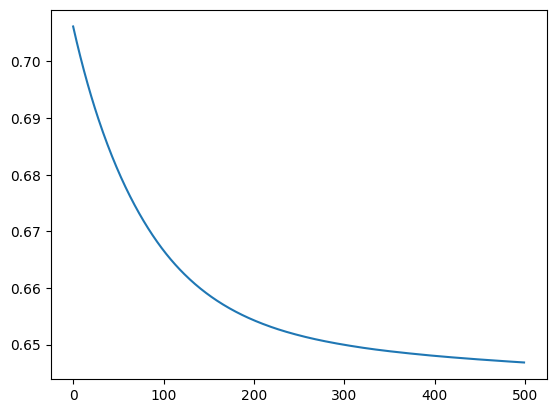

In [195]:
plt.plot(losses)

In [196]:
torch.manual_seed(0)
net = fwd_net.feed_forward(2, 100)
backpack.extend(net)

Sequential(
  (0): Linear(in_features=2, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=100, bias=True)
  (3): ReLU()
  (4): Linear(in_features=100, out_features=2, bias=True)
)

In [197]:
alpha = 7e-5

losses_kfac = []

for k in range(500):
    loss = loss_func(net(data_x), data_y.long())
    net.zero_grad()
    with backpack.backpack(backpack.extensions.KFAC()):
        loss.backward()
    for p in net.parameters():
        if k%100 == 0:
            if len (p.kfac) == 1:
                p.precond = torch.linalg.inv(p.kfac[0] + 1e-3 * torch.eye(p.kfac[0].size(0)))
            if len (p.kfac) == 2:
                p.precond = torch.kron(torch.linalg.inv(p.kfac[0] + 1e-3 * torch.eye(p.kfac[0].size(0))), torch.linalg.inv(p.kfac[1] + 1e-3 * torch.eye(p.kfac[1].size(0))))
    with torch.no_grad():
        for p in net.parameters():
            p.data -= alpha * (p.precond @ p.grad.flatten()).reshape(p.grad.shape)
            p.grad.zero_()
    
    losses_kfac.append(float(loss))

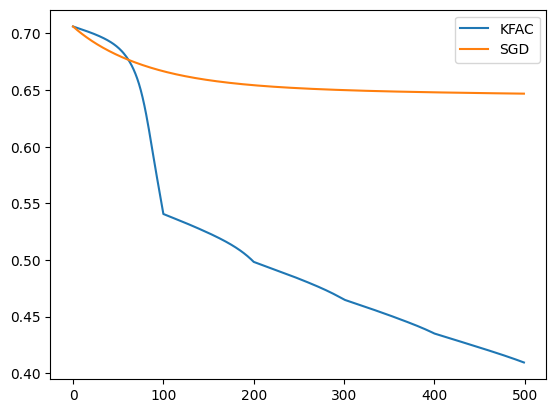

In [198]:
plt.plot(losses_kfac, label='KFAC')
plt.plot(losses, label='SGD')
plt.legend()

In [199]:
base_net

Sequential(
  (0): Linear(in_features=2, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=100, bias=True)
  (3): ReLU()
  (4): Linear(in_features=100, out_features=2, bias=True)
)

In [260]:
torch.manual_seed(0)
int_dim = 50
base_net = fwd_net.feed_forward(2, int_dim)
backpack.extend(base_net)
alpha = 5e-1
bs = 2000

losses = []

for k in range(500):
    perm = torch.randperm(data_x.size(0))[0:bs]
    data_x_batch = data_x[perm]
    data_y_batch = data_y[perm]
    loss = loss_func(base_net(data_x_batch), data_y_batch.long())
    base_net.zero_grad()
    loss.backward()
    with torch.no_grad():
        for p in base_net.parameters():
            p.data -= alpha * p.grad
            p.grad.zero_()
    
    losses.append(float(loss))
    

In [261]:
new_layer = torch.nn.Linear(int_dim, int_dim)
with torch.no_grad():
    new_layer.weight.copy_(torch.eye(int_dim))
    new_layer.bias.zero_()
setattr(new_layer.weight, 'is_new_param', True)
setattr(new_layer.bias, 'is_new_param', True)

ext_net_2 = torch.nn.Sequential(
    base_net[0],
    base_net[1],
    new_layer,
    torch.nn.ReLU(),
    base_net[2],
    base_net[3],
    base_net[4]
)
ext_net_1 = copy.deepcopy(ext_net_2)
losses_kfac = copy.deepcopy(losses)

In [262]:
### classical training:
for k in range(500):
    perm = torch.randperm(data_x.size(0))[0:bs]
    data_x_batch = data_x[perm]
    data_y_batch = data_y[perm]
    ext_net_1.zero_grad()
    loss = loss_func(ext_net_1(data_x_batch), data_y_batch.long())
    loss.backward()
    with torch.no_grad():
        for p in ext_net_1.parameters():
            if not hasattr(p, 'is_new_param'):
                p.data -= alpha * p.grad
                continue
            p.data -= alpha * p.grad
            p.grad.zero_()
    
    losses.append(float(loss))
    

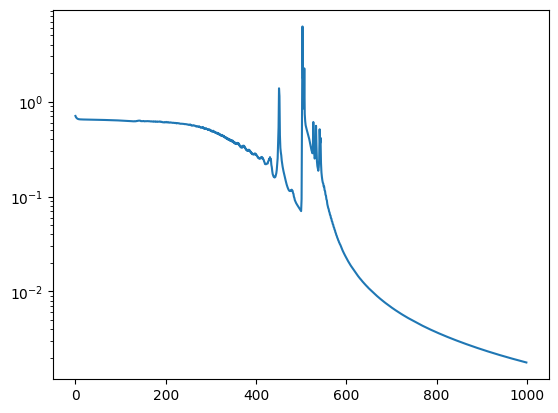

In [263]:
plt.plot(losses)
plt.yscale('log')

In [264]:
### use kfac for new parameters:
backpack.extend(ext_net_2)
loss = loss_func(ext_net_2(data_x), data_y.long())
with backpack.backpack(backpack.extensions.KFAC()):
    loss.backward()
    precond_weight = torch.kron(
        torch.linalg.inv(
            new_layer.weight.kfac[0] + 1e-3 * torch.eye(new_layer.weight.kfac[0].size(0))
        )
        ,
        torch.linalg.inv(
            new_layer.weight.kfac[1] + 1e-3 * torch.eye(new_layer.weight.kfac[1].size(0))
        )
    )
    precond_bias = torch.linalg.inv(
        new_layer.bias.kfac[0] + 1e-3 * torch.eye(new_layer.bias.kfac[0].size(0))
    )
    
    setattr(new_layer.weight, 'precond', 1e-3 * precond_weight)
    setattr(new_layer.bias, 'precond', 1e-3 * precond_bias)


In [265]:
for k in range(500):
    perm = torch.randperm(data_x.size(0))[0:bs]
    data_x_batch = data_x[perm]
    data_y_batch = data_y[perm]
    ext_net_2.zero_grad()
    loss = loss_func(ext_net_2(data_x_batch), data_y_batch.long())
    loss.backward()
    with torch.no_grad():
        for p in ext_net_2.parameters():
            if hasattr(p, 'precond') and k < 100:
                p -= alpha * (p.precond @ p.grad.flatten()).reshape(p.grad.shape)
                continue
            p.data -= alpha * p.grad
            p.grad.zero_()
    
    losses_kfac.append(float(loss))

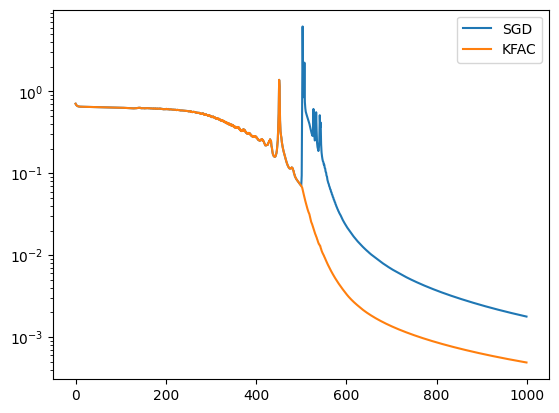

In [266]:
plt.plot(losses, label='SGD')
plt.plot(losses_kfac, label='KFAC')
plt.legend()
plt.yscale('log')